In [1]:
!pip install torchgeo segmentation_models_pytorch

In [2]:
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import tempfile
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples, ChesapeakeDE, NAIP
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

In [3]:
#Check mounted device type:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
#Check GPU details if found:
!nvidia-smi

Sat Apr 12 18:23:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Dataset extracted from : https://www.kaggle.com/datasets/luizclaudioandrade/naip-chesapeake-sample

Upload to and mount GDrive to use it with this notebook

In [5]:
#Define dataset dir:
INPUT_DIR = '/content/drive/MyDrive/datasets/naip_chesapeake_sample'

In [6]:
#Define Custom datasets:
class NAIPImages(RasterDataset):
    filename_glob = "m_*.tif"
    is_image = True
    separate_files = False

class ChesapeakeLabels(RasterDataset):
    filename_glob = "m_*.tif"
    is_image = False
    separate_files = False

In [7]:
#Testing if our datasets are working properly:
naip_root = os.path.join(INPUT_DIR, 'naip_images')
naip_images = NAIPImages(
    paths=naip_root,
)
print(naip_images)

chesapeake_root = os.path.join(INPUT_DIR, "chesapeake_labels")
chesapeake_labels = ChesapeakeLabels(
    paths=chesapeake_root,
)
print(chesapeake_labels)

NAIPImages Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=440002.8, maxx=451549.8, miny=4288884.0, maxy=4303429.2, mint=0.0, maxt=9.223372036854776e+18)
    size: 4
ChesapeakeLabels Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=440002.9842051893, maxx=451549.3842051893, miny=4288884.327921044, maxy=4303428.927921044, mint=0.0, maxt=9.223372036854776e+18)
    size: 4


In [8]:
# perform intersection operation (only keep data which is present in both datasets = Image + Labels/Masks):
dataset = naip_images & chesapeake_labels
# dataset_test = naip_test & chesapeake

Converting ChesapeakeLabels res from (0.6000000000000023, 0.6) to (0.6, 0.6)


In [9]:
#Configure our sampler with number of crops (length) and crop_size (size):
sampler = RandomGeoSampler(dataset, size=128, length=1000)
# sampler_test = RandomGeoSampler(dataset_test, size=128, length=500)

#configure Pytorch dataloader:
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples, batch_size=16)
# dataloader_test = DataLoader(dataset_test, sampler=sampler_test, collate_fn=stack_samples, batch_size=16)

In [11]:
# Specify colors for each class using hex codes
class_colors = [
    "#000000", "#ff001e", "#ff8f9c", "#56a100",
    "#b3b3b3", "#3bfcff", "#0004ff", "#ff00ff",
    "#f2ff00", "#00ff1e", '#fcba03', '#d66f00',
    '#006875', '#e0bb00'
]

class_names = [
    'No Data', 'Water', 'Wetlands', 'Tree Canopy',
    'Shrubland', 'Low Vegetation', 'Barren', 'Structures',
    'Impervious Surfaces', 'Impervious Roads', 'Tree Canopy over Structures',
    'Tree Canopy over Impervious Surfaces', 'Tree Canopy over Impervious Roads',
    'Aberdeen Proving Ground'
]

# Create a colormap with the given colors
colormap = ListedColormap(class_colors)

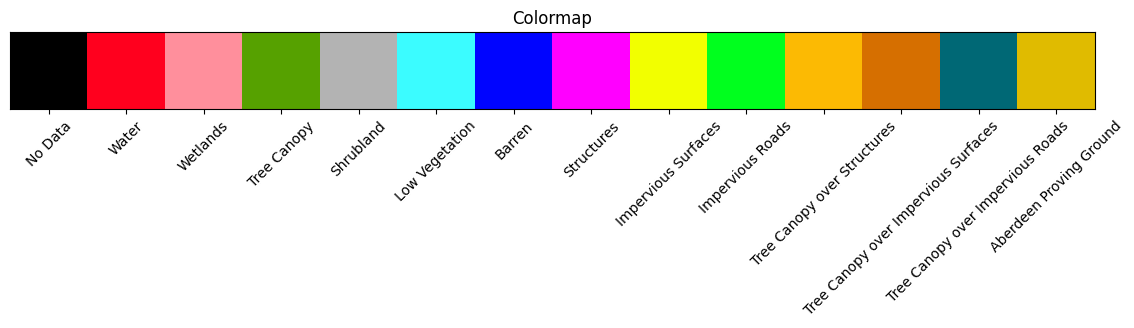

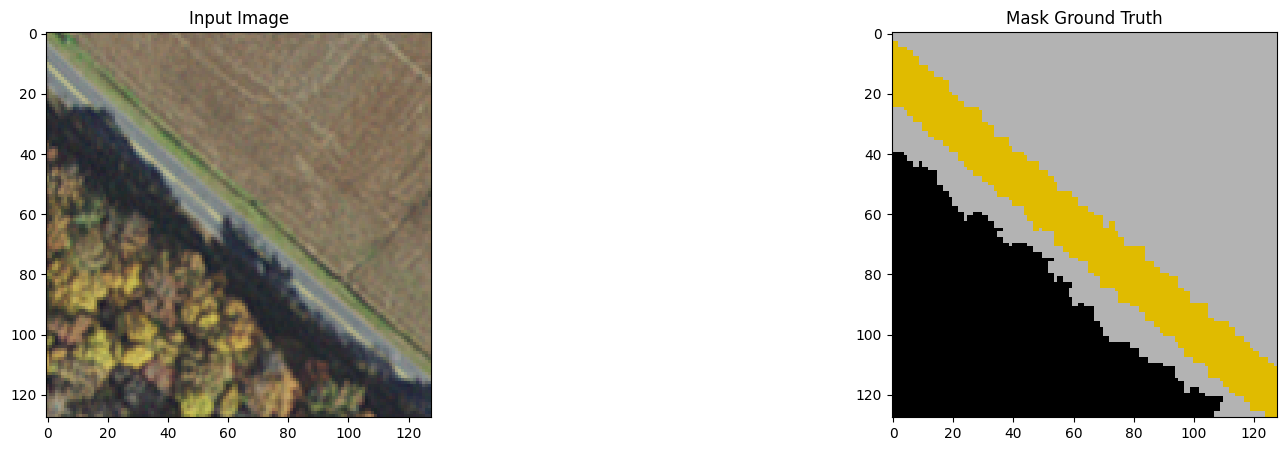

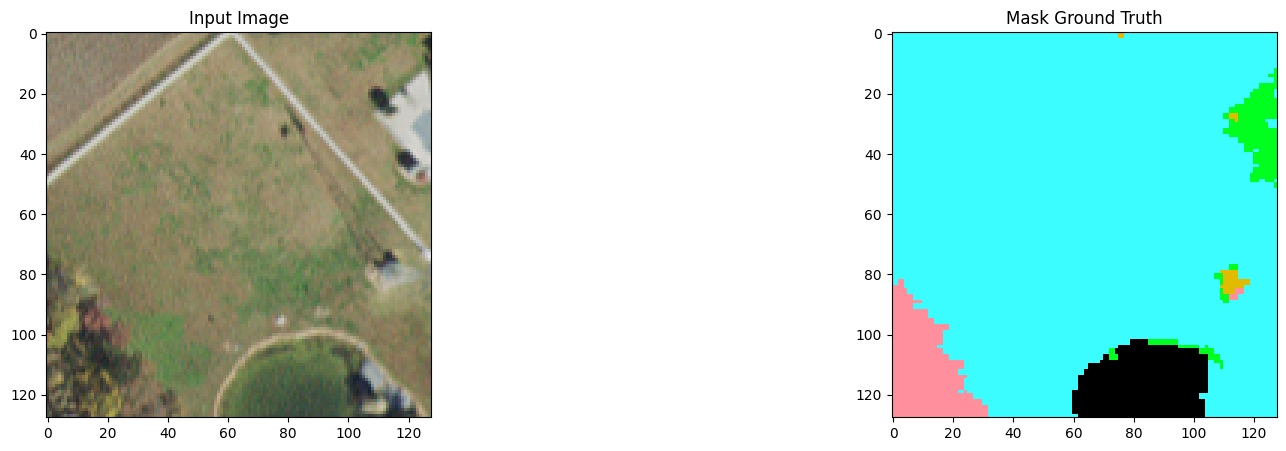

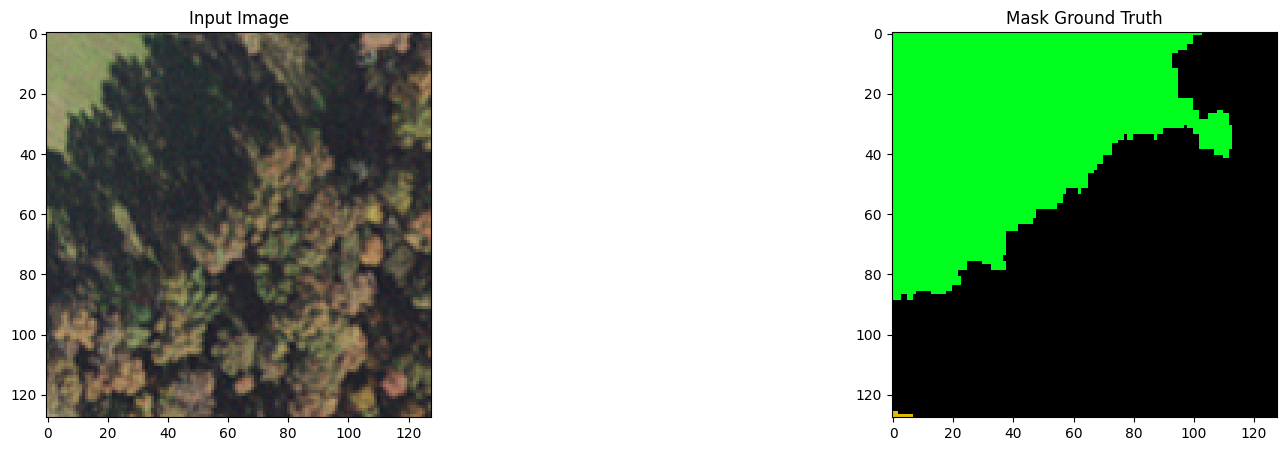

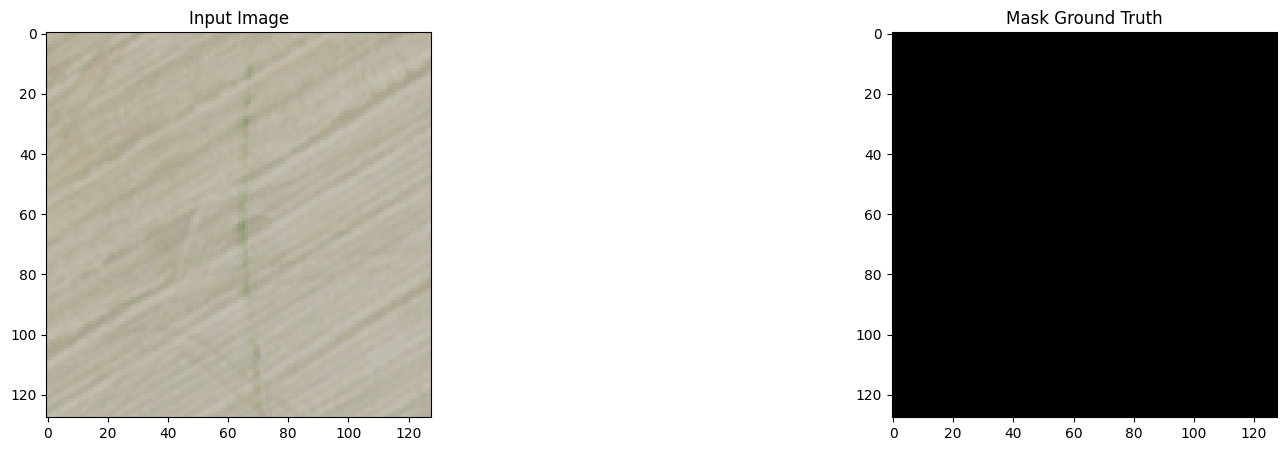

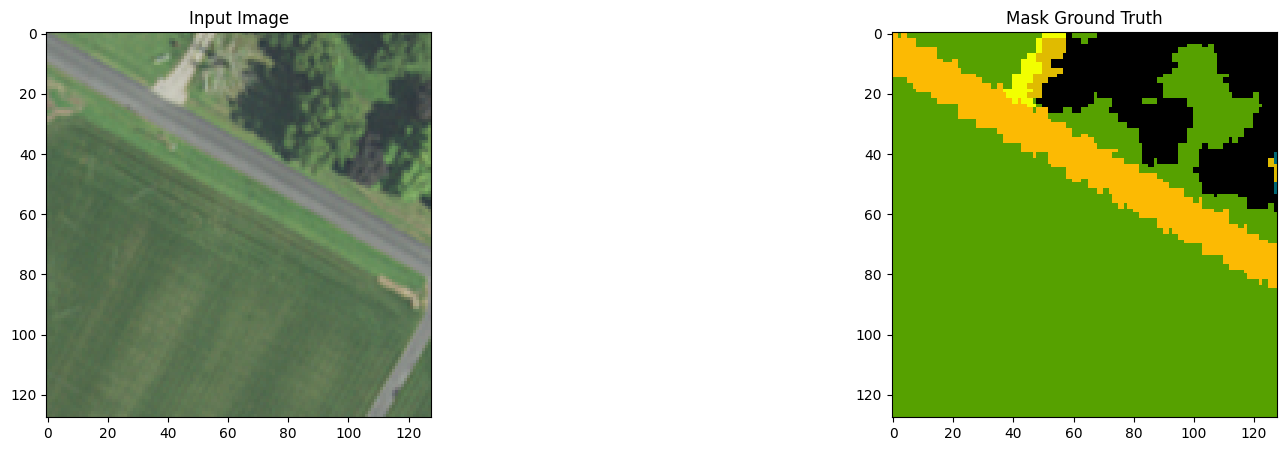

In [12]:
# lets look at some samples
num_samples = 5
dataloader_plot = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples, batch_size=1)

# Create a seperate figure and plot the colormap
plt.figure(figsize=(14, 1))
plt.imshow(np.arange(14).reshape(1, 14), cmap=colormap, aspect='auto', origin='lower')
plt.xticks(range(14), class_names, rotation=45, fontsize=10)
plt.yticks([])  # Hide y-axis ticks
plt.title("Colormap")
plt.show()

#iterate over samples and display them:
for i in range(num_samples):
    plt.figure(figsize=(20, 5))
    sample = next(iter(dataloader_plot))
    plt.subplot(1,2,1)
    plt.title("Input Image")
    plt.imshow(sample["image"][:,:3,:,:].squeeze().permute(1, 2, 0).type(torch.int64)) # for visualization we have to transpose back to HWC
    plt.subplot(1,2,2)
    plt.title("Mask Ground Truth")
    plt.imshow(sample["mask"].permute(1, 2, 0).type(torch.int64), cmap=colormap)  # for visualization we have to remove 3rd dimension of mask


    plt.show()

In [13]:
#Define Accuracy metric:
def acc(label, predicted):
    seg_acc = (label.cpu() == torch.argmax(predicted, axis=1).cpu()).sum() / torch.numel(label.cpu())
    return seg_acc

In [14]:
#Define Model:
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=14,                      # model output channels (number of classes in your dataset)
)

if str(device) == 'cuda':
        print("model is cuda")
        model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = smp.losses.DiceLoss('multiclass', from_logits=True)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
min_loss = torch.tensor(float('inf'))

os.makedirs('./saved_models', exist_ok=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 128MB/s]


model is cuda


In [22]:
import copy

N_EPOCHS = 10

plot_losses = []
scheduler_counter = 0
best_model = None

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, sample in enumerate(dataloader):
      x,y = sample["image"][:,:3,:,:], sample["mask"]#[:,:3,:]
      sample=None
      pred_mask = model(x.to(device).float())
      loss = criterion(pred_mask, y.to(device).type(torch.int64))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      print(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, sample in enumerate(dataloader): #temp using same dataloader as train
      x,y = sample["image"][:,:3,:,:], sample["mask"]#[:,:3,:]
      sample=None
      with torch.no_grad():
          pred_mask = model(x.to(device).float())
      val_loss = criterion(pred_mask, y.to(device).type(torch.int64))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())

  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch,
                                                                                                  np.mean(loss_list),
                                                                                                  np.mean(acc_list),
                                                                                                  np.mean(val_loss_list),
                                                                                                  np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])

  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
    best_model = copy.deepcopy(model)

  if scheduler_counter > 5:
      lr_scheduler.step()
      print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
      scheduler_counter = 0

[Epoch 0/10] [Batch 0/63] [Loss: 0.418684 (0.418684)]
[Epoch 0/10] [Batch 1/63] [Loss: 0.171230 (0.294957)]
[Epoch 0/10] [Batch 2/63] [Loss: 0.426303 (0.338739)]
[Epoch 0/10] [Batch 3/63] [Loss: 0.401254 (0.354368)]
[Epoch 0/10] [Batch 4/63] [Loss: 0.484742 (0.380443)]
[Epoch 0/10] [Batch 5/63] [Loss: 0.460153 (0.393728)]
[Epoch 0/10] [Batch 6/63] [Loss: 0.604674 (0.423863)]
[Epoch 0/10] [Batch 7/63] [Loss: 0.438937 (0.425747)]
[Epoch 0/10] [Batch 8/63] [Loss: 0.491791 (0.433085)]
[Epoch 0/10] [Batch 9/63] [Loss: 0.532856 (0.443062)]
[Epoch 0/10] [Batch 10/63] [Loss: 0.408977 (0.439964)]
[Epoch 0/10] [Batch 11/63] [Loss: 0.258370 (0.424831)]
[Epoch 0/10] [Batch 12/63] [Loss: 0.500723 (0.430669)]
[Epoch 0/10] [Batch 13/63] [Loss: 0.430303 (0.430643)]
[Epoch 0/10] [Batch 14/63] [Loss: 0.440747 (0.431316)]
[Epoch 0/10] [Batch 15/63] [Loss: 0.460853 (0.433162)]
[Epoch 0/10] [Batch 16/63] [Loss: 0.198006 (0.419330)]
[Epoch 0/10] [Batch 17/63] [Loss: 0.326677 (0.414182)]
[Epoch 0/10] [Batch 

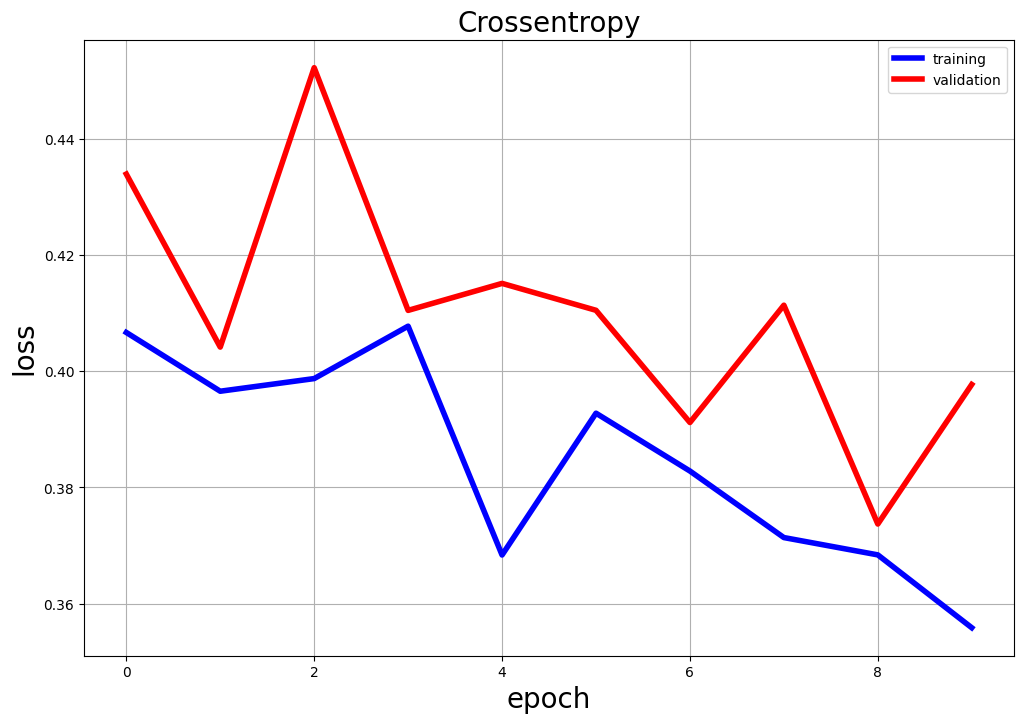

In [23]:
# plot loss
plot_losses = np.array(plot_losses)
plt.figure(figsize=(12,8))
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title("Crossentropy", fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.savefig('loss_plots.png')

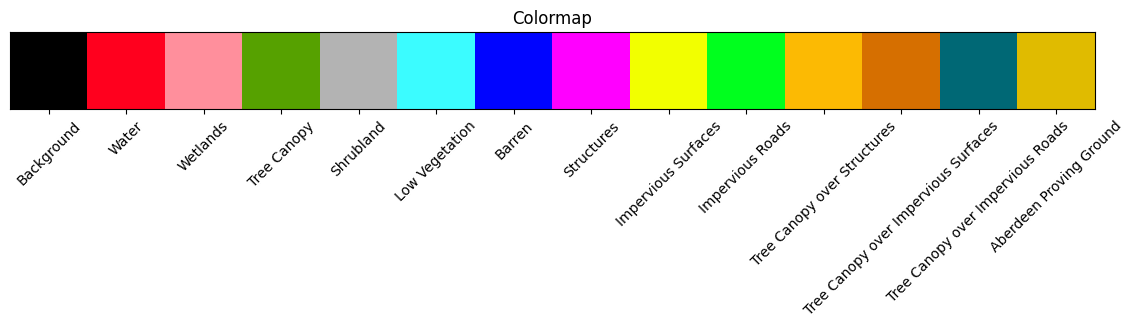

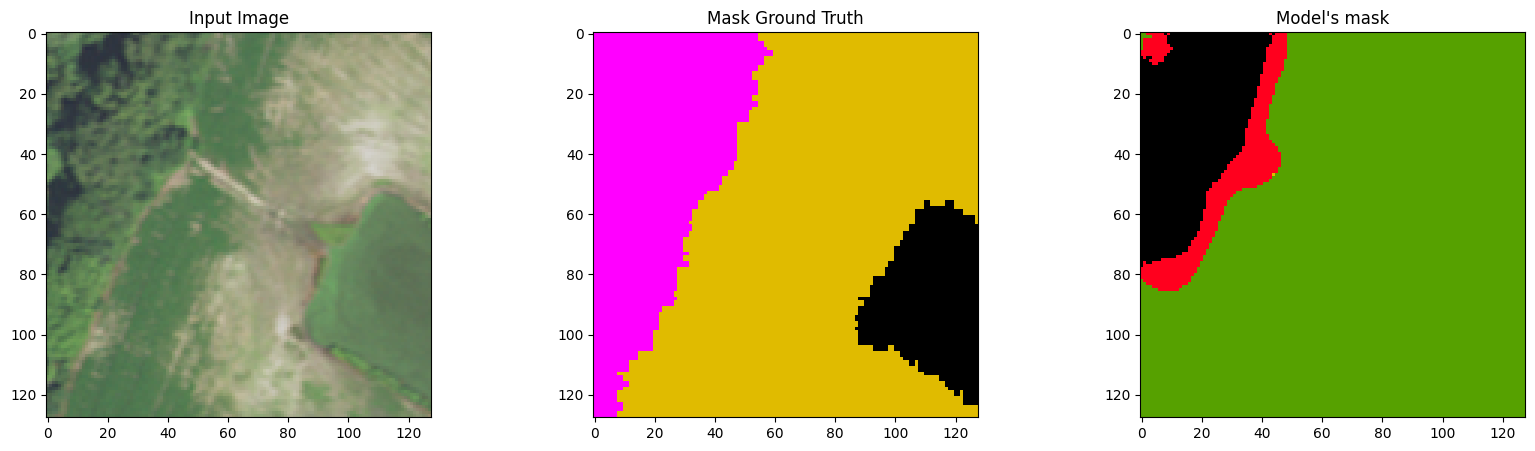

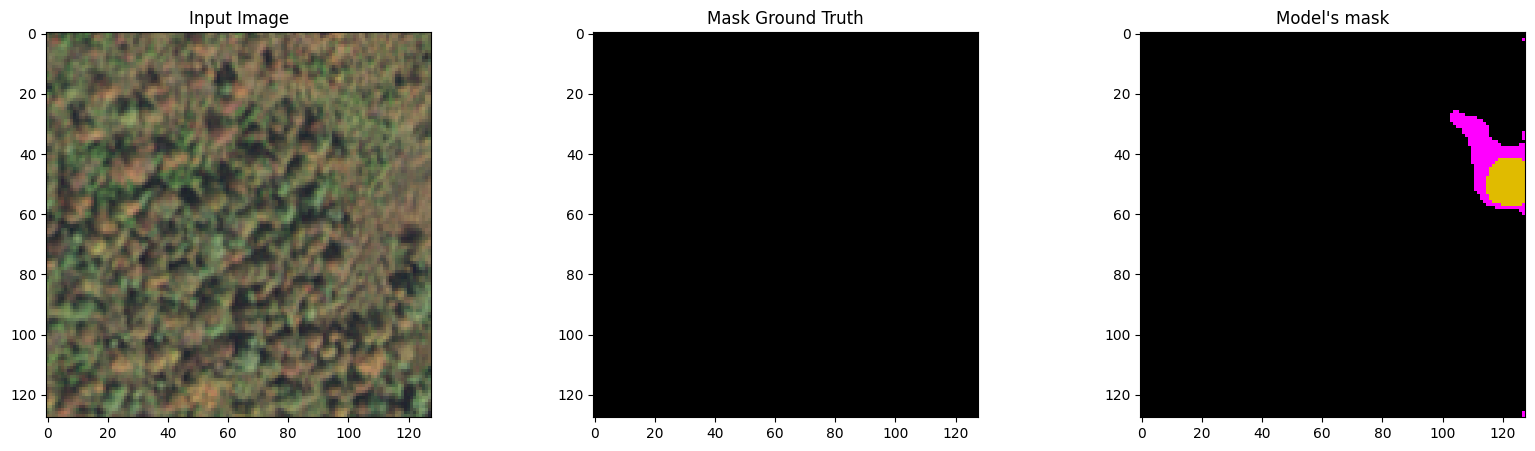

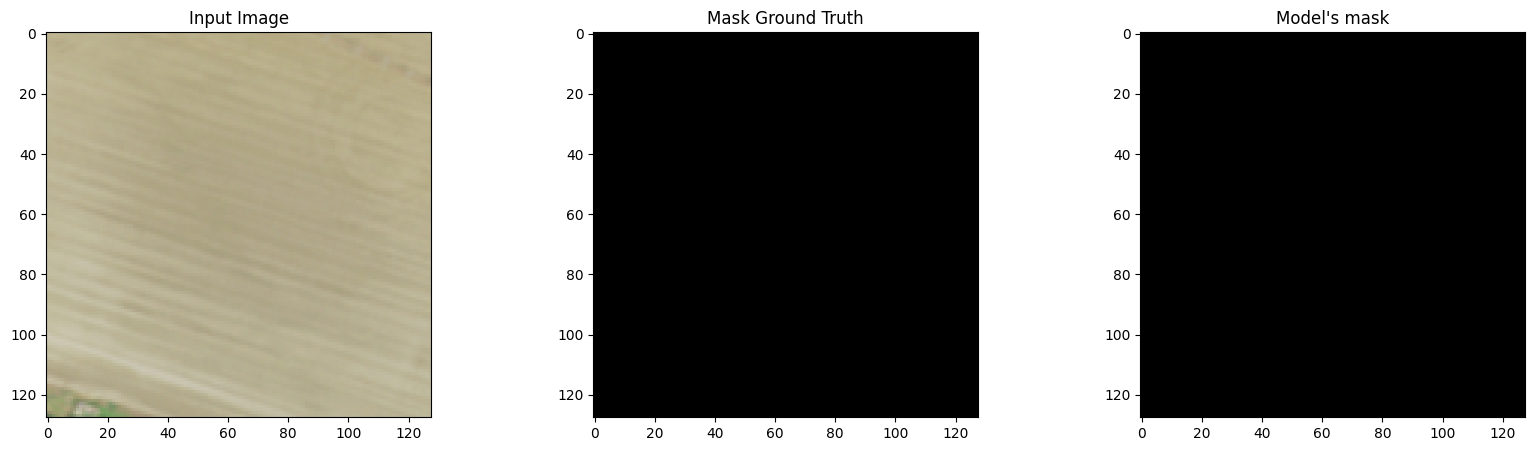

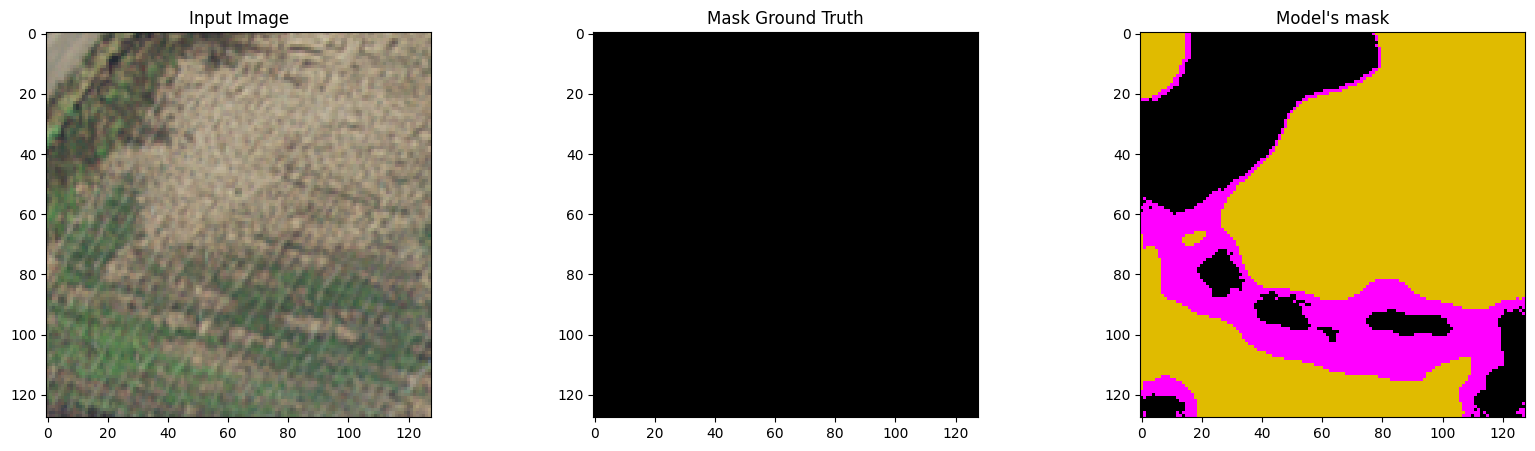

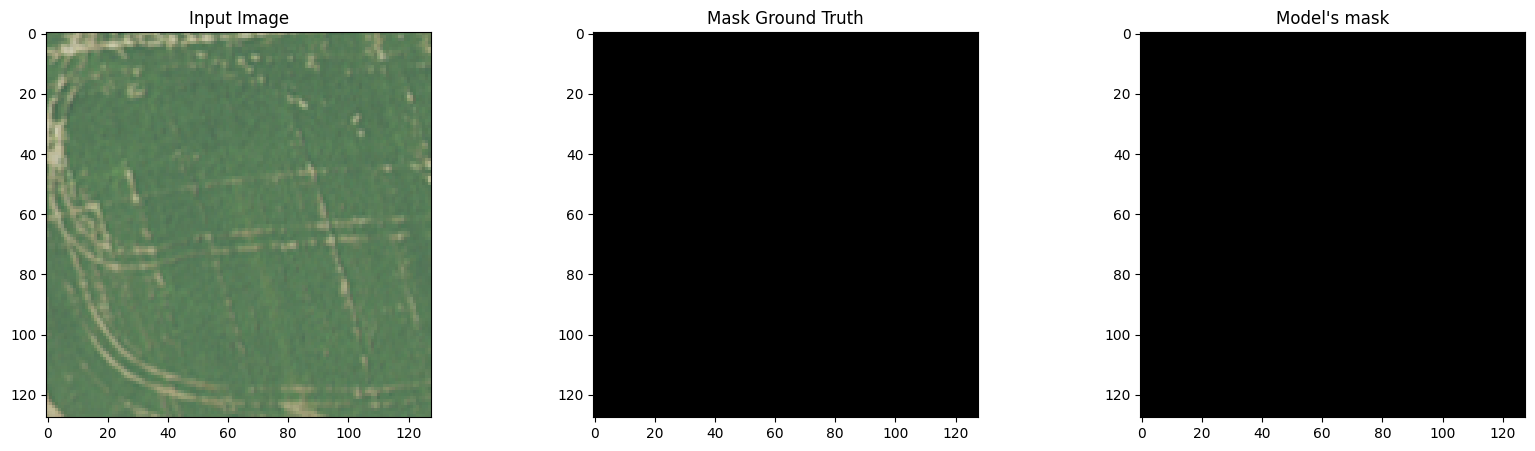

In [25]:
# lets look at some samples
num_samples = 5
dataloader_plot = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples, batch_size=1)

# Specify colors for each class using hex codes
class_colors = [
    "#000000", "#ff001e", "#ff8f9c", "#56a100",
    "#b3b3b3", "#3bfcff", "#0004ff", "#ff00ff",
    "#f2ff00", "#00ff1e", '#fcba03', '#d66f00',
    '#006875', '#e0bb00'
]

class_names = [
    'Background', 'Water', 'Wetlands', 'Tree Canopy',
    'Shrubland', 'Low Vegetation', 'Barren', 'Structures',
    'Impervious Surfaces', 'Impervious Roads', 'Tree Canopy over Structures',
    'Tree Canopy over Impervious Surfaces', 'Tree Canopy over Impervious Roads',
    'Aberdeen Proving Ground'
]

# Create a colormap with the given colors
colormap = ListedColormap(class_colors)

# Create a seperate figure and plot the colormap
plt.figure(figsize=(14, 1))
plt.imshow(np.arange(14).reshape(1, 14), cmap=colormap, aspect='auto', origin='lower')
plt.xticks(range(14), class_names, rotation=45, fontsize=10)
plt.yticks([])  # Hide y-axis ticks
plt.title("Colormap")
plt.show()

#iterate over samples and display them:
for i in range(num_samples):
    plt.figure(figsize=(20, 5))
    sample = next(iter(dataloader_plot))
    model.eval()
    output = model(sample["image"][:,:3,:,:].float().to(device)).detach().type(torch.int64)
    plt.subplot(1,3,1)
    plt.title("Input Image")
    plt.imshow(sample["image"][:,:3,:,:].squeeze().permute(1, 2, 0).type(torch.int64)) # for visualization we have to transpose back to HWC
    plt.subplot(1,3,2)
    plt.title("Mask Ground Truth")
    plt.imshow(sample["mask"].permute(1, 2, 0).type(torch.int64), cmap=colormap)  # for visualization we have to remove 3rd dimension of mask
    plt.subplot(1,3,3)
    plt.title("Model's mask")
    plt.imshow(output.argmax(dim=1).squeeze().type(torch.int64).cpu(), cmap=colormap)  # for visualization we have to remove 3rd dimension of mask
    # cbar = plt.colorbar(ticks=range(14), format='%1i', cmap=colormap)
    # cbar.ax.set_yticklabels(class_names)

    plt.show()